# 👽 Cell phenotyping using a Hierarchical Prior Knowledge Table

In [1]:
# import packages
import scimap as sm
import anndata as ad
import pandas as pd

Running SCIMAP  2.2.9


In [2]:
# Load the data that we saved in the last tutorial - (Prepare data for SCIMAP)
adata = ad.read_h5ad('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')

This method requires more work but is significantly more sensitive and scalable compared to clustering-based approaches.

### To run the method, you'll need two main components:

To successfully execute the method, you will need:

1. A `.csv` file containing manual gates. Should manual gates be absent, the algorithm will attempt to adjust the data by fitting two Gaussian distributions. Nonetheless, employing manual gating is recommended due to its heightened sensitivity.
2. A `.csv` file outlining a gating workflow strategy.

The execution of the algorithm is structured into three primary steps:

1. **Gate Identification**: Utilize `sm.pl.napariGater` to identify the gates.
2. **Data Rescaling**: Apply `sm.pp.rescale` to adjust the data based on the identified gates.
3. **Phenotyping**: Process the rescaled data using `sm.tl.phenotype` to run the phenotyping algorithm.

### Step 1: Define manual gates

In [3]:
%gui qt

This method will launch a napari window displaying several layers, each representing a different gate. You can toggle these layers on and off with the goal of identifying the gate that most accurately captures the positive cells. It's crucial to zoom and pan through the image to ensure the selected gate encompasses all positive cells throughout the image. Bear in mind that achieving 100% accuracy might not be feasible, so a certain margin of error may need to be accepted. This process is iterative, meaning adjustments may be necessary even after initial phenotyping and analysis. Manual gating must be conducted independently for each marker and each image.

In [4]:
image_path = '/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/registration/exemplar-001.ome.tif'

In [6]:
sm.pl.napariGater (image_path, adata) # new method

/var/folders/k5/3pb7tmfn0551jy0cf67ljdf00000gq/T/ipykernel_8388/1794404260.py:1: UserWarning:

NOTE: napariGater() is currently in beta testing. If you encounter any issues, please report them at: https://github.com/labsyspharm/scimap/issues



Initializing...
Loading image data...
Calculating contrast settings...
Initialization completed in 0.01 seconds
Opening napari viewer...
Napari viewer initialized in 0.91 seconds
Gate confirmed for CD57 at 7.00
Gate confirmed for ELANE at 7.80
Gate confirmed for CD45 at 6.40
Gate confirmed for CD11B at 7.60
Gate confirmed for SMA at 7.50
Gate confirmed for CD16 at 6.50
Gate confirmed for ECAD at 7.35
Gate confirmed for FOXP3 at 7.36
Gate confirmed for NCAM at 7.00


In [7]:
# check the gates
adata.uns['gates']

,exemplar-001--unmicst_cell
markers,
CD11B,7.60
CD16,6.50
CD45,6.40
CD57,7.00
ECAD,7.35
ELANE,7.80
FOXP3,7.36
NCAM,7.00
SMA,7.50


Remember to save the `adata` object to ensure that the gates are preserved. 🖴 You can perform partial gating and return later to complete the rest. The function keeps track of the markers and images you’ve already gated and will display this information in the interface when you return. 🔄🎯

### Importing Gates via a CSV File 📄✨

If you’re not using **`napariGater()`**, you can also import gates using a CSV file. Here are two important points to keep in mind:

1️⃣ The **marker column** must be named exactly as `"markers"` 🏷️.  
2️⃣ The remaining columns should contain the **gates** for each image in the dataset. 🖼️ Ensure the column names precisely match the `'imageid'` column in the `adata` object. 🧬 You can retrieve it by typing:  
   ```python
   adata.obs['imageid']
   ```

---

### Multiple Images and Uniform Gates 🛠️  
If you have multiple images and want to apply the **same gate** to all of them, you have two options:

1️⃣ Copy-paste the same gate values across all columns in your CSV file. 🖋️  
2️⃣ Alternatively, use just one column named **"gates"** (with no additional columns). In this case, the same gate will be applied to all images in your dataset, provided there is more than one image. ✅  

---

### A Final Note 📝  
When you run the `rescale` function without specifying anything for the `gate` parameter, it will try to auto-identify gates using a **GMM (Gaussian Mixture Model)** function. ⚠️ **However, this method is generally not very accurate**, and we discourage relying on it. 🚫  

If gates are missing for some images or markers, the GMM will be automatically applied. 🔄 **Be cautious** when interpreting results for those images or markers! 🧐  

--- 

With these tips, you’ll have more control over your gating process! 🚀

In [8]:
# Do the above step for each marker and then create a `.csv` file like below:
pd.read_csv('/Users/aj/Partners HealthCare Dropbox/Ajit Nirmal/nirmal lab/resources/exemplarData/scimapExampleData/manual_gates.csv')

,markers,exemplar-001--unmicst_cell
0,ELANE,7.80
1,CD57,8.90
2,CD45,6.40
3,CD11B,7.60
4,SMA,NaN
5,CD16,6.50
6,ECAD,7.35
7,FOXP3,NaN
8,NCAM,7.00


You'll observe that the first column lists the markers present in the dataset, while the second column specifies the gate, named after the specific image's ID found in `adata.obs['imageid']`. This  is especially useful when dealing with datasets containing multiple images, as it allows for a distinct column for each image. I have also intentionally left out 2 markers (SMA and FOXP3) where GMM will be applied automatically. You can control the GMM using the `gmm_components` parameter.

Although visual gating has proven to be the most sensitive method for us, you can also apply single and bi-marker gating approaches, similar to FACS, to assist in determining a threshold.

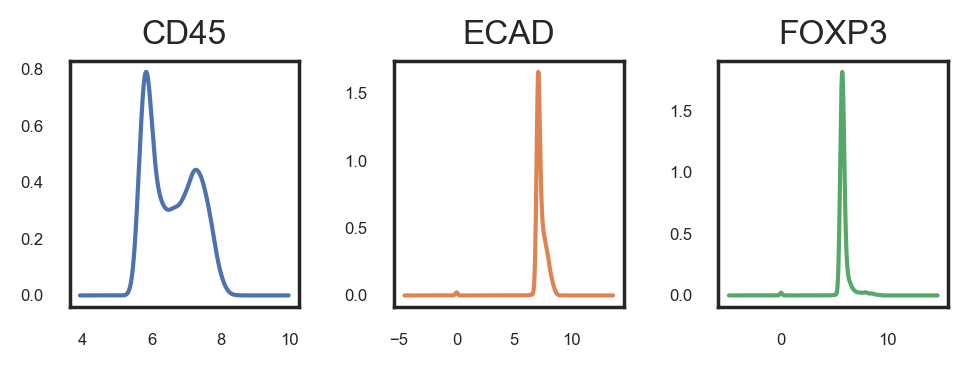

In [9]:
# single 
sm.pl.distPlot(adata, layer='log', markers=['CD45','ECAD','FOXP3'], ncols=3, fontsize=6, figsize=(5,2))

We also use bimarker gating to identify a gate

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



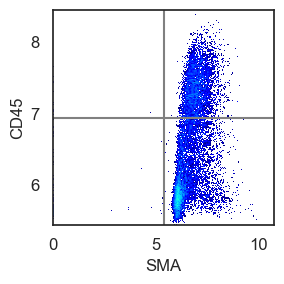

In [10]:
sm.pl.densityPlot2D(adata, markerA='SMA', markerB='CD45', layer='log')


### Step 2: Rescale the data

You can provide gating information by either inputting a `manual_gates.csv` file into the `gate` parameter or, if you used **`napariGater`**, directly using `adata.uns['gates']`. 

For markers **not included** in the `manual_gates.csv` file, the function automatically identifies gates using a **Gaussian Mixture Model (GMM)** algorithm. This provides thresholds for markers where manual gates are unavailable. 🎯  

In [12]:
# Load the manual gates from CSV and rescale the data based on the gates
manual_gate = pd.read_csv('/Users/aj/Partners HealthCare Dropbox/Ajit Nirmal/nirmal lab/resources/exemplarData/scimapExampleData/manual_gates.csv')
adata = sm.pp.rescale (adata, gate=manual_gate)

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:145: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Running GMM for image: exemplar-001--unmicst_cell
Applying GMM to markers: SMA, FOXP3

Scaling Image: exemplar-001--unmicst_cell
Scaling ELANE (gate: 7.800)
Scaling CD57 (gate: 8.900)
Scaling CD45 (gate: 6.400)
Scaling CD11B (gate: 7.600)
Scaling SMA (gate: 6.597)
Scaling CD16 (gate: 6.500)
Scaling ECAD (gate: 7.350)
Scaling FOXP3 (gate: 6.307)
Scaling NCAM (gate: 7.000)


As you can see GMM was automatically applied to SMA and FOXP3

### Step 3: Run the phenotyping algorithm

In [13]:
# load the phenotyping workflow
phenotype = pd.read_csv('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/phenotype_workflow.csv')
# view the table:
phenotype.style.format(na_rep='')

,Unnamed: 0,Unnamed: 1,ELANE,CD57,CD45,CD11B,SMA,CD16,ECAD,FOXP3,NCAM
0,all,ECAD+,,,,,,,pos,,
1,all,Immune,,,pos,,,,,,
2,all,SMA+,,,,,pos,,,,
3,Immune,NK cells,,allpos,,neg,,allpos,,,
4,Immune,Other myeloid cells,,,,pos,,,,,
5,Immune,Treg,,,,,,,,pos,
6,Other myeloid cells,Dendritic cells,,allneg,,,,allneg,,,


As it can be seen from the table above,  

1. The `first column` has to contain the cell that are to be classified.  
2. The `second column` indicates the phenotype a particular cell will be assigned if it satifies the conditions in the row.  
3. `Column three` and onward represent protein markers. If the protein marker is known to be expressed for that cell type, then it is denoted by either `pos`, `allpos`. If the protein marker is known to not express for a cell type it can be denoted by `neg`, `allneg`. If the protein marker is irrelevant or uncertain to express for a cell type, then it is left empty. `anypos` and `anyneg` are options for using a set of markers and if any of the marker is positive or negative, the cell type is denoted accordingly.

**To give users maximum flexibility in identifying desired cell types, we have implemented various classification arguments as described above for strategical classification. They include**

- allpos
- allneg
- anypos
- anyneg
- pos
- neg
  
`pos` : "Pos" looks for cells positive for a given marker. If multiple markers are annotated as `pos`, all must be positive to denote the cell type. For example, a Regulatory T cell can be defined as `CD3+CD4+FOXP3+` by passing `pos` to each marker. If one or more markers don't meet the criteria (e.g. CD4-), the program will classify it as `Likely-Regulatory-T cell`, pending user confirmation. This is useful in cases of technical artifacts or when cell types (such as cancer cells) are defined by marker loss (e.g. T-cell Lymphomas).
  
`neg` : Same as `pos` but looks for negativity of the defined markers. 
  
`allpos` : "Allpos" requires all defined markers to be positive. Unlike `pos`, it doesn't classify cells as `Likely-cellType`, but strictly annotates cells positive for all defined markers.
  
`allneg` : Same as `allpos` but looks for negativity of the defined markers. 
  
`anypos` : "Anypos" requires only one of the defined markers to be positive. For example, to define macrophages, a cell could be designated as such if any of `CD68`, `CD163`, or `CD206` is positive.
  
`anyneg` : Same as `anyneg` but looks for negativity of the defined markers. 

In [14]:
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype, label="phenotype") 

Phenotyping ECAD+
Phenotyping Immune
Phenotyping SMA+
-- Subsetting Immune
Phenotyping NK cells
Phenotyping Other myeloid cells
Phenotyping Treg
-- Subsetting Other myeloid cells
Phenotyping Dendritic cells
Consolidating the phenotypes across all groups


/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [15]:
# Summary of the phenotyping
adata.obs['phenotype'].value_counts()

phenotype
Immune                 3977
ECAD+                  2873
SMA+                   1947
Unknown                1496
Treg                    657
Other myeloid cells     170
NK cells                 64
Dendritic cells          17
Name: count, dtype: int64

## Visualisation of the Results

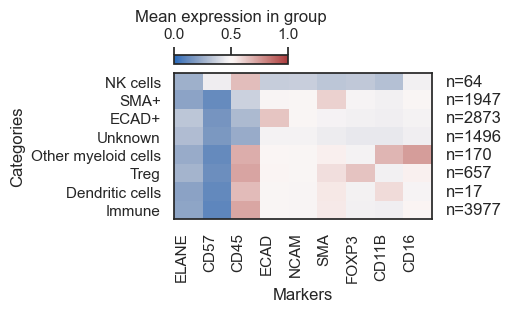

In [16]:
# Heatmap (here values over 0.5 are considered positive as we have scaled the data)
sm.pl.heatmap(adata, groupBy='phenotype', standardScale=None, figsize=(5,3), showPrevalence=True, vmin=0, vmax=1)

In [17]:
# view the phenotype on a UMAP
adata = sm.tl.umap(adata)


/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/plotting/umap.py:304: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



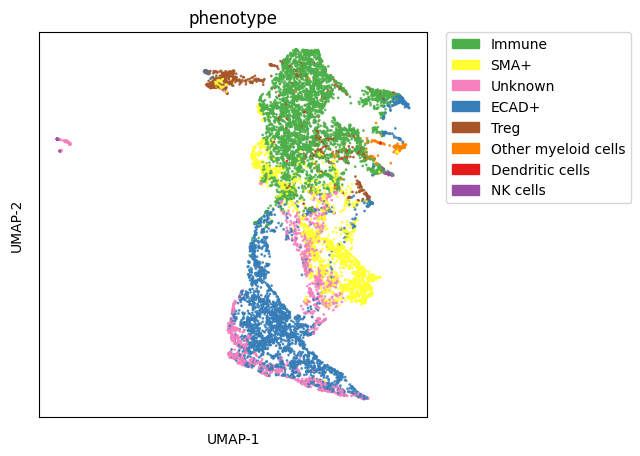

In [22]:
sm.pl.umap(adata, color=['phenotype'], s=1)

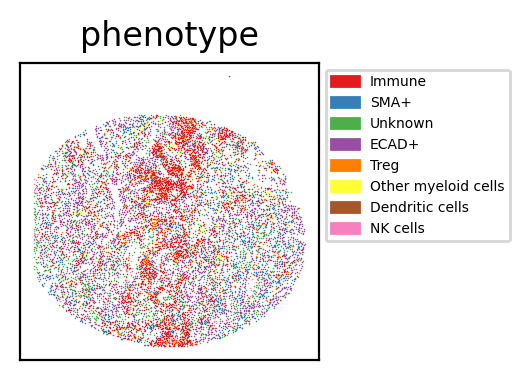

In [19]:
# spatial scatter plot to look at the distribution of cells
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(2.75,2), s=0.3, fontsize=5, catCmap='Set1')

In [20]:
# View the results by overlaying it on the raw image
image_path = '/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/registration/exemplar-001.ome.tif'

# view in napari
sm.pl.image_viewer(image_path=image_path, 
                   adata=adata, 
                   overlay='phenotype', 
                   point_size=10,
                   point_color='white')

# Note that if your AnnotatedData object (adata) includes multiple images, 
# you can use the `subset` parameter to specify the image name found in the `imageid` column, 
# enabling the loading of just that particular image.

### Save Results

In [18]:
# Save the results
adata.write('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')